<a href="https://colab.research.google.com/github/antwon87/CMPE256_Project/blob/main/Textwords_compare_dsktch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this code is to import the captions of the pictures from the flickr30 database. A single document will be created from each set of descriptions for the picture. Then an LSH algorith will be applied to the descriptions using the "Datasketch" toolbox. From here queries can be run to find matching pictures from the flickr30 database from description queries.

In [5]:
%pip install datasketch

In [ ]:
from csv import reader
import string
import re
#import binascii
import random
from datasketch import MinHash, MinHashLSH
import PIL
import matplotlib.pyplot as plt

In [6]:
doc_dict = {}

In [8]:
file_object = open("/content/drive/Shareddrives/Scary_project/archive.zip (Unzipped Files) (1)/mod_captions.txt", "r")
csv = reader(file_object, delimiter = "|")
for row in csv:
  key = row[0]+row[1]
  value = row[2]
  #Remove punctuation and make lower case
  value = value.translate(str.maketrans('', '', string.punctuation)).lower()
  #Remove extra white spaces
  value = re.sub(" +", " ", value)
  #Add all of the descriptions together
  #if key in doc_dict:
  #  doc_dict[key] = doc_dict[key] + value
  #else:
  doc_dict[key] = value  
file_object.close()

In [9]:
doc_dict['33497646.jpg1']

'a young man performs yoga inspired by a beautiful day on the beach '

In [10]:
doc_dict['33497646.jpg2']

'a man in printed board shorts is doing a yoga pose on the beach '

In [11]:
doc_dict['33497646.jpg3']

'a man in swim trunks poses in a yoga stance on the beach '

Convert docs to shingles

In [101]:
#set_dict maps photo id to set representation of photo description found in doc_dict.
#May use this dictionary to #evaluate results of LSH output.
#Loop through each photo description, convert them into shingles, add them to a hash
#set which will be the value for the set_dict dictionary.

#This variable will set the number of shingles in the following function
n_shingles = 3

#This function takes a string input and converts it to a list of shingles
def get_shinglelist(string_input, n_shingles):
  words = string_input.split()
  temp_list = []
  #use for 2 word shingles
  #use for single word shingles
  if n_shingles == 1:
    for index in range(len(words)):
      shingle = words[index]
      temp_list.append(shingle.lower())
  elif n_shingles == 2:
    #use for 2 word shingles
    for index in range(0, len(words) - 1):
      shingle = words[index] + " " + words[index + 1]
      temp_list.append(shingle.lower())
  elif n_shingles == 3:
    #use for 3 word shingles
    for index in range(0, len(words) - 2):
      shingle = words[index] + " " + words[index + 1] + " " + words[index + 1]
      temp_list.append(shingle.lower())
  return temp_list

set_dict={} 
for key, value in doc_dict.items():
  temp_list = get_shinglelist(value, n_shingles)
  set_dict[key] = set(temp_list)


In [102]:
set_dict['1000092795.jpg0']

{'at their their',
 'guys with with',
 'hair look look',
 'hands while while',
 'hanging out out',
 'in the the',
 'look at at',
 'out in in',
 'shaggy hair hair',
 'their hands hands',
 'two young young',
 'while hanging hanging',
 'with shaggy shaggy',
 'young guys guys'}

Create minHash signatures

In [103]:
#num_perm is the number of permutations we want for the MinHash algorithm. The higher the permutations the longer the runtime.
#Min_dict maps photo id to min hash signatures.
#We loop through all the set representations of photo descriptions and calculate the signatures and store them in the min_dict dictionary.

num_perm = 128
min_dict = {}
for key, val in set_dict.items():
   m = MinHash(num_perm=num_perm)
   for shingle in val:
       m.update(shingle.encode('utf8'))
   min_dict[key] = m

Create LSH index

In [106]:
#We set the Jaccard similarity threshold as a parameter in MinHashLSH.
#We loop through the signatures or keys in the min_dict dictionary and store them as bands.
#Datasketch stores these in a dictionary format, where the key is a photo id and the values
#are all the photo ids deemed similar based on the threshold.
threshold = 0.4
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
for key in min_dict.keys():
   lsh.insert(key,min_dict[key])

In [82]:

test_qry_list = (
    'Four guys three wearing hats one not are jumping at the top of a staircase .',
    'A brown dog runs with a stick in its mouth and a black dog follows .',
    'A man in a worn Arizona ball cap , polo shirt , and dark pants stitches something on his lap .',
    'A gray-haired man sets up a new office with a desk built into the wall , a phone and a lamp .',
    'A group of people in red clothing with scooters ride down the hill on rollerblades .',
    'A young blond woman is putting together a table while a young brunette is reading her the instructions .',
    'Man in yellow shirt performing maintenance on Schwinn bicycle near a picnic table .',
    'Several people are watching others play inside an inflatable moon bounce carnival attraction',
    'A woman looks at a billboard advertising the 2010 World Cup games .',
    'A young woman carrying a small handbag and wearing earmuffs walks on a street .'
)

In [77]:
#This function takes an input string and hashes it in the same way as 
#the strings in the MSH/LSH
def hash_qry(qry_str_input):
  temp_list = get_shinglelist(qry_str_input, n_shingles)
  hash_shingle_set = set(temp_list)
  qry_minhash = MinHash(num_perm=num_perm)
  for shingle in hash_shingle_set:
    qry_minhash.update(shingle.encode('utf8'))
  return qry_minhash


In [78]:
#test_qry = 'a man shorts is doing a yoga pose on the beach'
#test_qry = 'two young guys hanging out in the yard'
#test_qry = 'A young woman carrying a small handbag and wearing earmuffs walks on a street .'
#hashed_query = hash_qry(test_qry)

In [79]:
#The Datasketch library includes a query function
#result = lsh.query(hashed_query)

In [107]:
num_matches = []
for test_qry in test_qry_list:
  hashed_query = hash_qry(test_qry)
  result = lsh.query(hashed_query)
  num_matches.append(str(len(result)))

print(num_matches)

['0', '30', '1', '0', '12', '0', '0', '0', '0', '1']


In [80]:
print(result)
print("Found "+str(len(result))+" possible matches")

['7998492801.jpg0', '3228960484.jpg0', '4431540400.jpg3', '2891924845.jpg1', '7794723066.jpg2', '4299331724.jpg2', '3423225860.jpg2', '4430468539.jpg2', '6842319991.jpg3', '1303727066.jpg0', '4537666932.jpg3', '3561635009.jpg2', '4230695941.jpg2', '2976155358.jpg0', '2435486484.jpg0', '870710405.jpg2', '446902282.jpg1', '2906759254.jpg1', '4431540400.jpg2', '4299244891.jpg0', '2799871904.jpg2', '3975881094.jpg1', '3381747300.jpg3', '3737539561.jpg0', '161347959.jpg0', '3972665750.jpg2', '2102531792.jpg0', '250346988.jpg0', '4752799475.jpg4', '4817644923.jpg2', '700884207.jpg4', '3548430221.jpg0', '6707604119.jpg3', '4780491039.jpg1', '4504942600.jpg0', '2367317953.jpg0', '3165123595.jpg1', '3800395431.jpg2', '7718605530.jpg2', '5897488202.jpg2', '2428997777.jpg0', '3563461991.jpg0', '4062259729.jpg0', '6187926673.jpg2', '536537638.jpg2', '3105315670.jpg3', '2429272699.jpg3', '4860096411.jpg2', '3909183873.jpg0', '2664250718.jpg0', '3434112918.jpg2', '4443309552.jpg0', '289742991.jpg0',

3334040774.jpg


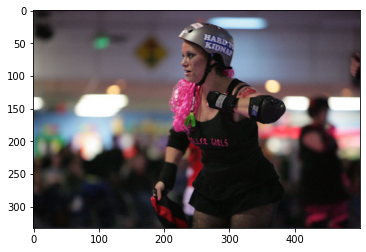

2741990005.jpg


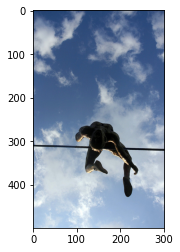

4801016849.jpg


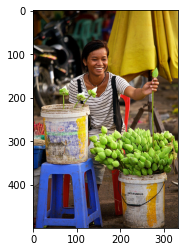

584726817.jpg


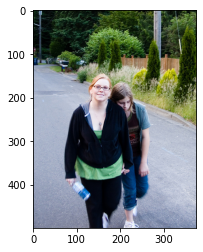

6848905653.jpg


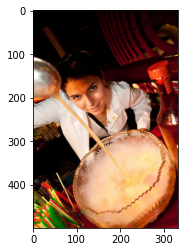

In [75]:
for i in range(5):
  pic_id = result[i].split('.')
  pic_num = pic_id[0]
  print(pic_num + '.jpg')
  img = PIL.Image.open(f'/content/drive/Shareddrives/Scary_project/archive.zip (Unzipped Files)/images/{pic_num}.jpg')
  plt.imshow(img)
  plt.show()

Example code from Datasketch

In [ ]:

set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

In [ ]:
m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)

In [ ]:
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

In [ ]:
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)
result

['m3', 'm2']